# Predicting Health Inspection Violaitons from Yelp Reviews and Business Attributes

## 1. Environment Setup

In [1]:
import psycopg2 as psy
import pandas as pd
import re
import numpy as np
import ast


from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
import scipy.sparse
import sklearn.pipeline as pipe

## 2. Data Preparation

Connect to database and download initial datasets. These datasets are materialized views of the Yelp business data converted from JSON format, and the Toronto Inspection dataset imported from CSV. All attributes have been normalized to remove leading spaces, JSON tags, and unreadable characters.

In [2]:
#set up connection to our DB
conn = psy.connect(database="sterndsyelp", 
                        user="mvsternds", 
                        password="nyustern123!", 
                        host="sterndsyelp.cawzspvmqd5q.us-east-1.rds.amazonaws.com", 
                        port="5432"
                       )
#open cursor and check our tables in the DB
cur = conn.cursor()

In [4]:
#get Yelp review text
cur.execute("SELECT * FROM public.toronto_reviews")
reviews = pd.DataFrame(cur.fetchall())
reviews.columns = ['bizID','reviewID','userID','type','stars','text','useful','funny','cool','date']

#get total reviews per biz
rev = reviews['bizID'].value_counts()
rev_counts = pd.DataFrame(rev).reset_index()
rev_counts.columns = ['bizID','all_review_count']

### Join Yelp Review Data with Inspection Dataset

#### Levenshtein Distance (in-database) 
This option joins the yelp restaurant informaiton to each inspection record where:
 * The [Levenshtein distance](https://xlinux.nist.gov/dads/HTML/Levenshtein.html) of the restaurant name from the two datasets is <3
 * The distance of the address from each dataset is <4
 * The date of the review is greater than the prior inspection date
 * The date of the review is less than or equal to inspeciton date on the record
 * The absolute value difference of the "star" rating in the review is less than or equal to 2 (this may reduce biased reviews that are too far from the mean)
 
Whitespace at the beginning and end of the name and address in each dataset is trimmed, and the strings are converted to uppercase before matching. The mathcing thresholds can be adjusted to increase potential for matching, or decrease false matches.

In [17]:
# The materialized view of the restaurant, inspection, and review data is "toronto_all"
cur.execute("SELECT * FROM public.toronto_all_3 where review_date is not null and attributes is not null order by  establishment_id, inspection_date" )
obs = pd.DataFrame(cur.fetchall())
obs.head()
obs.columns=['bizID','name','address','postal_code','neighborhood','lat','long','categories','attributes','is_open','review_cnt','hours','stars','setablishment_id','establishment_name','establishment_address','inspection_date','last_inspection','count_minor','count_sig','count_crucial','count_na','crucial_signficant','review_id','user_id','review_stars','review_text','useful','funny','cool','review_dt','last_insp_cs']
obs.head()

,bizID,name,address,postal_code,neighborhood,lat,long,categories,attributes,is_open,...,crucial_signficant,review_id,user_id,review_stars,review_text,useful,funny,cool,review_dt,last_insp_cs
0,tR5s0D0YRrh-fjFhb64O9w,TIMHORTONS,5975STEELESAVENUEE,M1V 5P6,Scarborough,43.8349423,-79.2569201,"['Bagels', 'Coffee & Tea', 'Food', 'Donuts']","['BikeParking: False', 'BusinessAcceptsCreditC...",1,...,0,CkETJtVfBwJ8vacVAGGVNg,l3iHVF_IeMiHzo8x1lmNtQ,3,"""Love the attitude of the staff here but on nu...",0,0,0,2016-12-21,0
1,nY2oBwH3s5sKox1mERIoVQ,EPICURECAFEGRILL,502QUEENSTREETW,M5V 2B3,Alexandra Park,43.6477412,-79.4012788,"['American (New)', 'Nightlife', 'Bars', 'Resta...","['Alcohol: full_bar', ""Ambience: {'romantic': ...",1,...,0,oBuXd6LY0GpGCNRr_zm4aA,bvcoVDag6g140bwtb0x4eg,4,"""So I've walked past this place numerous times...",0,0,0,2015-09-23,0
2,nY2oBwH3s5sKox1mERIoVQ,EPICURECAFEGRILL,502QUEENSTREETW,M5V 2B3,Alexandra Park,43.6477412,-79.4012788,"['American (New)', 'Nightlife', 'Bars', 'Resta...","['Alcohol: full_bar', ""Ambience: {'romantic': ...",1,...,0,lbvLED3-HVwXh-EeZ4OemQ,48ZbrRSE_fFKGyW_oCRGkQ,5,I had a very good experience at this place. T...,0,0,0,2015-08-29,0
3,nY2oBwH3s5sKox1mERIoVQ,EPICURECAFEGRILL,502QUEENSTREETW,M5V 2B3,Alexandra Park,43.6477412,-79.4012788,"['American (New)', 'Nightlife', 'Bars', 'Resta...","['Alcohol: full_bar', ""Ambience: {'romantic': ...",1,...,0,sgkcwpayw8uLLSjhLAgGqw,COxdRkjbxnvIDr-1NyiOhg,4,"""Food here is great for brunch...I've had it m...",0,0,0,2015-09-02,0
4,nY2oBwH3s5sKox1mERIoVQ,EPICURECAFEGRILL,502QUEENSTREETW,M5V 2B3,Alexandra Park,43.6477412,-79.4012788,"['American (New)', 'Nightlife', 'Bars', 'Resta...","['Alcohol: full_bar', ""Ambience: {'romantic': ...",1,...,0,S8EW6AVbMx8ynvk95Ol61w,ApVEdjV51Frz30df6Y2JXg,4,Nice cozy spot. Had the Mediterranean Bruschet...,0,0,0,2015-11-23,0


In [18]:
#create a primary key of restaurant ID and each unique inspection date for that restaurant
obs['bizID-dt'] = obs['bizID'] + "-" + obs['inspection_date'].map(str)

In [19]:
#get counts of in scope reviews for each inspeciton date of a given restaurant
in_scope_rev = obs['bizID-dt'].value_counts()
in_scope_reviews = pd.DataFrame(in_scope_rev).reset_index()
in_scope_reviews.columns = ['bizID-dt','count_reviews_in_scope']
in_scope_reviews.head()

,bizID-dt,count_reviews_in_scope
0,RwRNR4z3kY-4OsFqigY5sw-2015-11-03,233
1,jc3p5SFyt9qrrMXt6E13ig-2016-12-21,156
2,RwRNR4z3kY-4OsFqigY5sw-2016-03-15,148
3,h_4dPV9M9aYaBliH1Eoeeg-2016-05-12,138
4,trKyIRyjKqVSZmcU0AnICQ-2016-04-11,112


In [20]:
#get dummies for star rating column
obs = pd.concat([obs, pd.get_dummies(obs['review_stars'], prefix='stars')], axis=1)

In [21]:
#Get counts of each star rating for a given restaurant
stars = obs.groupby('bizID-dt')[['stars_1', 'stars_2','stars_3','stars_4','stars_5']].sum().reset_index()
stars.head()

,bizID-dt,stars_1,stars_2,stars_3,stars_4,stars_5
0,-2TBP3ZGu7M-FmfoNJvbrQ-2016-09-07,0,1,0,2,0
1,-2TBP3ZGu7M-FmfoNJvbrQ-2017-01-18,0,0,1,3,1
2,-76didnxGiiMO80BjSpYsQ-2015-09-01,1,1,0,0,0
3,-76didnxGiiMO80BjSpYsQ-2016-03-01,1,4,0,1,0
4,-76didnxGiiMO80BjSpYsQ-2016-09-29,2,3,0,1,1


In [22]:
#merge review text based on the business-inspection date primary key
combined_revs = obs.groupby('bizID-dt')['review_text'].apply(' '.join).reset_index()

In [23]:
#get a unique count of the users that reviewed the restaurant after the last inspection 
#and before the current inspection
users = obs.groupby('bizID-dt')['user_id'].count().reset_index()
users.columns = ['bizID-dt','count_unique_users']

In [24]:
sub = obs[['bizID-dt','bizID',
           'name','postal_code',
           'lat','long','categories',
           'attributes','is_open',
           'crucial_signficant','stars', 'last_insp_cs']]
sub = sub.drop_duplicates()

In [167]:
#merge in all data into one df
df1 = pd.merge(sub,stars,on='bizID-dt', how='left')
df2 = pd.merge(df1,combined_revs,on='bizID-dt', how='left')
df3 = pd.merge(df2,rev_counts,on='bizID', how='left')
df4 = pd.merge(df3,in_scope_reviews,on='bizID-dt', how='left')
df5 = pd.merge(df4,users,on='bizID-dt', how='left')


### Parsing the "Categories" and "Attributes" columns into unique features
The next cell parses the 'Categories' and 'Attributes' columns,which are nested dicitonaries of different attributesof each restaurant. The categroy column captures descriptive features such as the types of cuisine served, and wheter or not the restaurant is a bar. The atttributes column captures features such as the 'ambiance' of the restaurant, parking, noise level, and other unique features.

In [168]:
t = []
for i in range(len(df5['categories'])):
    x = ast.literal_eval(df5['categories'][i])
    t.append(x)
    
cats = pd.DataFrame(t)
cats_df = pd.get_dummies(cats, prefix='Category')
cats_df = cats_df.groupby(cats_df.columns, axis=1).sum()

atts_df = pd.DataFrame()
for x in range(len(df5['attributes'])):
    list_yelp = ast.literal_eval(df5['attributes'][x])

    attribute_list = []
    attribute_name = []

    for i in list_yelp:

        name = i.split(":")[0]
        values = i.split( name+": " )[1].replace('{','').replace('}','')

        if len(values.split(":")) > 1: 
        
            for j in values.split(","):
                name_j = name + "_" + (j.split(":")[0].strip().replace("'",''))
                attribute_name.append( name_j )
                attribute_list.append (j.split(":")[1])
        else:
            attribute_name.append( name )
            attribute_list.append ( values )
        
    dataframe = pd.DataFrame(attribute_list).transpose()
    dataframe.columns = attribute_name
    atts_df = atts_df.append(dataframe)
    
atts_df = atts_df.reset_index().drop('index', 1)

df = pd.concat([df5, cats_df, atts_df], axis=1)

Next, we create dummy variables for all of the attribute and category features that were generated in the previous step. We want to capture if the attribute is true, false, or nor applicable for the restaurant.

In [169]:
#dummy-ize all categorical and boolean variables
df=pd.get_dummies(df, columns=[
 'Alcohol',
 'Ambience_casual',
 'Ambience_classy',
 'Ambience_hipster',
 'Ambience_intimate',
 'Ambience_romantic',
 'Ambience_touristy',
 'Ambience_trendy',
 'Ambience_upscale',
 'BikeParking',
 'BusinessAcceptsCreditCards',
 'BusinessParking_garage',
 'BusinessParking_lot',
 'BusinessParking_street',
 'BusinessParking_valet',
 'BusinessParking_validated',
 'Caters',
 'GoodForKids',
 'GoodForMeal_breakfast',
 'GoodForMeal_brunch',
 'GoodForMeal_dessert',
 'GoodForMeal_dinner',
 'GoodForMeal_latenight',
 'GoodForMeal_lunch',
 'HasTV',
 'NoiseLevel',
 'OutdoorSeating',
 'RestaurantsAttire',
 'RestaurantsDelivery',
 'RestaurantsGoodForGroups',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsTableService',
 'RestaurantsTakeOut',
 'WiFi', 
 'is_open',
'BestNights_friday',
 'BestNights_monday',
 'BestNights_saturday',
 'BestNights_sunday',
 'BestNights_thursday',
 'BestNights_tuesday',
 'BestNights_wednesday',
     'ByAppointmentOnly',
 'CoatCheck',
 'DogsAllowed',
 'DriveThru',
 'GoodForDancing',
 'HappyHour',
 'Music_background_music',
 'Music_dj',
 'Music_jukebox',
 'Music_karaoke',
 'Music_live',
 'Music_no_music',
 'Music_video',
 'Open24Hours',
 'RestaurantsCounterService',
 'Smoking',
 'WheelchairAccessible'
  ]
  , dummy_na=True)


In [170]:
#useful code to view all columns of df
pd.set_option('display.max_columns', None)

In [171]:
#remove all of the extraneous features
#backup=df
del df['categories']
del df['attributes']
del df['name']
del df['bizID']
del df['bizID-dt']
del df['lat']
del df['long']
del df['postal_code']
#Make a True/False target variable to label each inspection event with wether or not a critical violaton was found
df['crucial_signficant']= (df['crucial_signficant']>0)*1

### Text feature extraction, stop word removal, and lemmatization

In [172]:
from nltk.corpus import stopwords
from stemming.porter2 import stem
import nltk
import string
#remove stopwords, clean punctuation, and stem 
stop = stopwords.words('english')
df['review_text']=df['review_text'].str.lower()
df['review_text'] = df['review_text'].apply(lambda x: '  '.join([word for word in x.split() if word not in (stop)]))
df['review_text'] = df['review_text'].str.replace('.',' ')
df['review_text'] = df['review_text'].str.replace('!',' ')
df['review_text'] = df['review_text'].str.replace(',',' ')
df['review_text'] = df['review_text'].str.replace('?',' ')
df['review_text'] = df['review_text'].str.replace('/',' ')
df['review_text'] = df['review_text'].str.replace('-',' ')

In [173]:
# ps = nltk.stem.WordNetLemmatizer()
# df['review_text']=df["review_text"].apply(lambda x:[ps.lemmatize(y,pos='v') for y in x.split()])
df['review_text']=df["review_text"].apply(lambda x:[stem(y) for y in x.split()])
df['review_text']=df['review_text'].apply(lambda x: ',  '.join(x))
translator = str.maketrans('', '', string.punctuation)
df['review_text'] = df['review_text'].str.translate(translator)
df['review_text'] = df['review_text'].replace(to_replace =' +',value=' ', regex=True)
df['stars'] = df.stars.astype(float)
df['review_text'].head(25)

0     love attitud staff numer occas bagel still tas...
1     so iv walk past place numer time and regret no...
2     nice cozi spot mediterranean bruschetta pepper...
3     this place awesom server friend non evas pasta...
4     group 9 lunch great lunch special alot choic m...
5     i go epicur occasion excel express lunch menu ...
6     this might look like newsstand conveni corner ...
7     im give 2 star rate unexpect unnecessari misha...
8     this review strict kimchi fri rice greatest iv...
9     24 hour subway els know it 3 want subway inste...
10    each time go charg differ type food order seem...
11    i would high recommend place north toronto sus...
12    this one favorit sushi restaur north toronto f...
13    probabl timmi know peopl hit drive spare chang...
14    this place great deal tasti look cheap vegan l...
15    they semi re brand known esther queen soup the...
16    if want get yell order mediocr soup place you ...
17    we breakfast quit busi friday afternoon im

In [174]:
import gc
gc.collect()

748

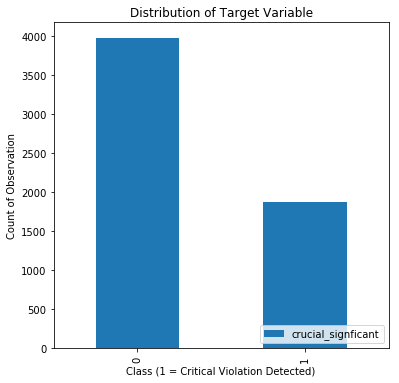

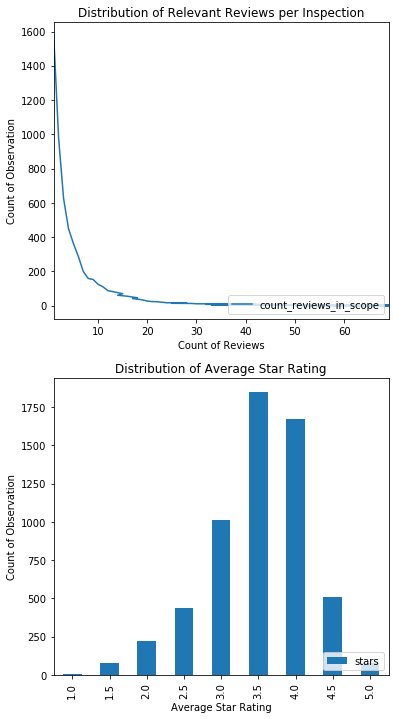

In [175]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 6, 6
pd.value_counts(df['crucial_signficant']).plot(kind="bar")
plt.xlabel('Class (1 = Critical Violation Detected)')
plt.ylabel('Count of Observation')
plt.title('Distribution of Target Variable')
plt.legend(loc="lower right")
plt.show()
plt.rcParams['figure.figsize'] = 6,12 

plt.figure(1)

plt.subplot(211)
pd.value_counts(df['count_reviews_in_scope']).plot()
plt.xlabel('Count of Reviews')
plt.ylabel('Count of Observation')
plt.title('Distribution of Relevant Reviews per Inspection')
plt.legend(loc="lower right")

plt.subplot(212)
counts = pd.value_counts(df['stars']).sort_index()
counts.plot(kind="bar")
plt.xlabel('Average Star Rating')
plt.ylabel('Count of Observation')
plt.title('Distribution of Average Star Rating')
plt.legend(loc="lower right")

plt.show()

## 3. Modeling and Text Vectorization
First, we import all necessary packages. By comparing the results of several vectorizing methods as well as several moeling methods, we can determine which combination yield best performance.

In [176]:
df_test = df[df['count_reviews_in_scope'] >0]
#keep only the obs that are within +3 to -3 standard deviations in the column 'count_reviews_in_scope'.
# df[np.abs(df.count_reviews_in_scope-df.count_reviews_in_scope.mean())<=(3*df.count_reviews_in_scope.std())]
X_ntext = df_test.drop(['review_text','crucial_signficant'], axis=1)
from sklearn.feature_extraction.text import TfidfVectorizer
#separate the non text features so that we only transform the text
X_text = df_test['review_text']
X_ntext = df_test.drop(['review_text','crucial_signficant'], axis=1)

In [178]:
# set up a few different vectorizers to test
count_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3))
bigram_vectorizer = TfidfVectorizer(ngram_range = (1,3))

### Linear Regression
##### Basic Linear Regression 3-fold CV , TfidfVectorizer(ngram_range = (1,3))

In [179]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy import interp
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.model_selection import StratifiedKFold

In [180]:
#vectorize using trigram tfidf vectorizer and 3-gram features
X1 = scipy.sparse.hstack((bigram_vectorizer.fit_transform(df_test.review_text), X_ntext.values),format='csr')
Y1 = df_test['crucial_signficant']

#create train/test split
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y1, train_size=.75)

#build LR model using the tfidf trigram vectorier
lr = LogisticRegression()
lr_parameters = {'C':[0.0001,0.001,0.1,1,10],
                'penalty':['l1','l2']}

lr_cv = GridSearchCV(lr,lr_parameters)
lr_cv.fit(X_train1,Y_train1)

print("Best parameters set found on development set:"+str(lr_cv.best_params_))

Best parameters set found on development set:{'C': 0.1, 'penalty': 'l1'}


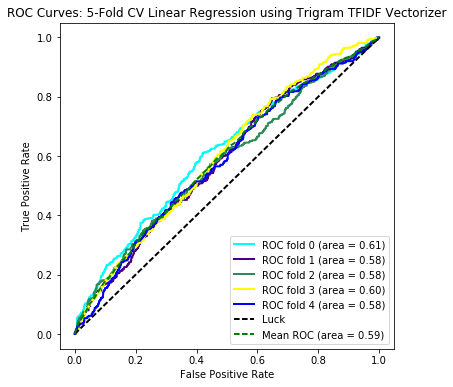

In [181]:
cv = StratifiedKFold(n_splits=5)
classifier = lr_cv
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(cv.split(X1, Y1), colors):
    probas_ = classifier.fit(X1[train], Y1[train]).predict_proba(X1[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y1[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(X1, Y1)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.rcParams['figure.figsize'] = 6, 6
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: 5-Fold CV Logistic Regression using Trigram TFIDF Vectorizer')
plt.legend(loc="lower right")
plt.show()
#  print ("Average AUC using 5-fold CV and optimized parameters on test data with TFIDF Vectorizer = %.3f" % 
#         np.mean(cross_val_score(lr_cv, X_test1, Y_test1, scoring="roc_auc", cv=5)))

##### Basic Linear Regression 3-fold CV , CountVectorizer(binary=True, ngram_range=(1, 3))

In [182]:
#vectorize using count vectorizer and create train/test split
X2 = scipy.sparse.hstack((count_vectorizer.fit_transform(df_test.review_text), X_ntext.values),format='csr')
Y2 = df['crucial_signficant']

#create train/test split
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, train_size=.75)

#build LR model using the count vectorier
lr2 = LogisticRegression()
lr_parameters = {'C':[0.0001,0.001,0.01,0.1,1,10],
                'penalty':['l1','l2']}
lr_cv2 = GridSearchCV(lr,lr_parameters)
lr_cv2.fit(X_train2, Y_train2)

print("Best parameters set found on development set:"+str(lr_cv2.best_params_))

Best parameters set found on development set:{'C': 0.0001, 'penalty': 'l1'}


In [ ]:
cv = StratifiedKFold(n_splits=5)
classifier = lr_cv2
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(cv.split(X2, Y2), colors):
    probas_ = classifier.fit(X2[train], Y2[train]).predict_proba(X2[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y2[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(X2, Y2)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: 5-Fold CV Logistic Regression using Trigram Count Vectorizer')
plt.legend(loc="lower right")
plt.show()
# auc = np.mean(cross_val_score(lr_cv2, X_test2, Y_test2, scoring="roc_auc", cv=5))
# print ("Average AUC using 5-fold CV and optimized parameters on test data with Count Vectorizer = %.3f" % 
#      auc  )

### Random Forest, 5-fold CV, Count Trigram Vectorization

In [ ]:
from sklearn.ensemble import RandomForestClassifier
cv = StratifiedKFold(n_splits=5)
classifier = RandomForestClassifier()
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(cv.split(X2, Y2), colors):
    probas_ = classifier.fit(X2[train], Y2[train]).predict_proba(X2[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y2[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(X2, Y2)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: 3-Fold CV Random Forest using Trigram Count Vectorizer')
plt.legend(loc="lower right")
plt.show()

print ("Area under the ROC curve on test data = %.3f" % metrics.roc_auc_score(rf.predict(X_test2), Y_test2))

*Other methods including Gradient Descent and a Restricted Boltazman Machine Neural Net are implemented below. Because the count vectorizer performed better than the TFIDF vectorizer, we use this vectorization in these methods.*

### Linear Support Vector Classification, 5-fold CV, TFIDF Trigram Vectorization

In [ ]:
from sklearn import svm,
cv = StratifiedKFold(n_splits=5)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(cv.split(X1, Y1), colors):
    probas_ = classifier.fit(X1[train], Y1[train]).predict_proba(X1[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y1[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(X1, Y1)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.rcParams['figure.figsize'] = 6, 6
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: 5-Fold CV Linear SVM using Trigram TFIDF Vectorizer')
plt.legend(loc="lower right")
plt.show()

### Restricted Boltzmann Machine

In [ ]:
# from sklearn.neural_network import BernoulliRBM

# X1 = scipy.sparse.hstack((bigram_vectorizer.fit_transform(df_test.review_text), X_ntext))
# Y1 = df_test['crucial_signficant']
# X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y1, train_size=.75)

# model = BernoulliRBM()
# model.learning_rate = 0.06
# model.n_iter = 20
# # More components tend to give better prediction performance, but larger
# # fitting time
# model.n_components = 100

# model.fit(X_train1, Y_train1)
# auc_nn = metrics.roc_auc_score(model.predict(X_test1), Y_test1)
# print ("Area under the ROC curve on test data = %.3f" % aud_nn )